In [2]:
import re
import os
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ase.io import read

np.set_printoptions(suppress=True, linewidth=100000)
plt.rcParams.update({'font.size': 20})

def re_int(string_sub, string_search):
    return int(re.sub(string_sub, '', re.search(r'%s\d+' % (string_sub), string_search).group()))

def re_float(string_sub, string_search):
    return float(re.sub(string_sub, '', re.search(r'%s[-]?\d+[.]\d+' % (string_sub), string_search).group()))

# hub1d
<div>
<img src="fig/bs_fig_4.png" width="500"/>
</div>

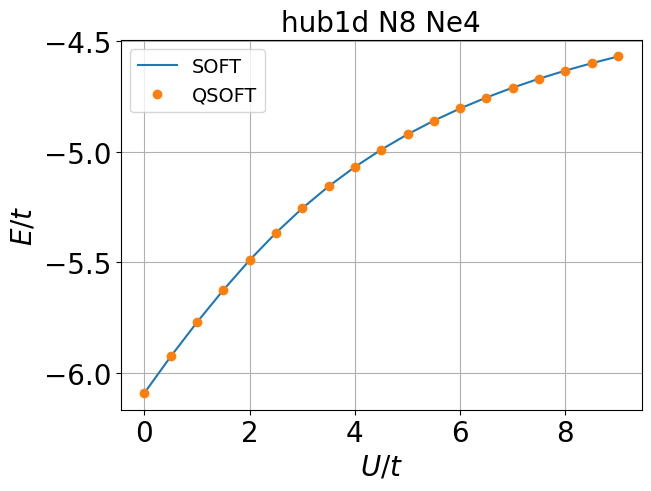

In [2]:
def show_E_U(dir_output, method=['soft', 'qsoft']):
    system, params = dir_output.split('/')[::2]
    marker = ['none', 'o']
    linestyle=['-', 'none']
    
    data = []
    for i, m in enumerate(method):
        data_i = []
        for fn in [fn for fn in os.listdir(dir_output) if re.match(f'{m}_hamiltonian', fn)]:
            data_i.append([re_float('_U', fn), re_float('_e', fn)])
        data_i = np.array(data_i)
        data.append(data_i[data_i[:, 0].argsort()])
    data = np.array(data)

    fig, ax = plt.subplots(constrained_layout=True)
    for d, m, mk, ls in zip(data, method, marker, linestyle):
        ax.plot(d[:, 0], d[:, 1], marker=mk, linestyle=ls, label=f'{m.upper()}')
    ax.set_xlabel(r'$U/t$')
    ax.set_ylabel(r'$E/t$')
    ax.set_title(re.sub('_', ' ', f'{system} {params}'), fontsize='medium')
    ax.legend(fontsize='x-small')
    ax.grid(True)
    plt.show()
    
show_E_U('hub1d/output/N8_Ne4', method=['soft', 'qsoft'])

# hchain
<div>
<img src="fig/bs_fig_5.png" width="500"/>
</div>

method=espresso
N = 8
R = 1.0
dir_output = /home/yerin/qdft/output/N8/espresso_R1.00



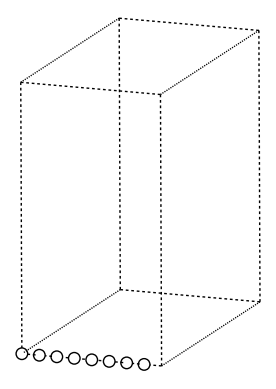

In [33]:
from hchain.lib.dft import DFT
from ase.visualize.plot import plot_atoms

def show_structure(N, R):
    fig, ax = plt.subplots()
    dft = DFT('espresso', N, R, keep_old=True) 
    plot_atoms(dft.atoms, ax, rotation=('-15x,20y,-5z'))
    ax.set_axis_off()
    plt.show()

show_structure(8, 1.0)

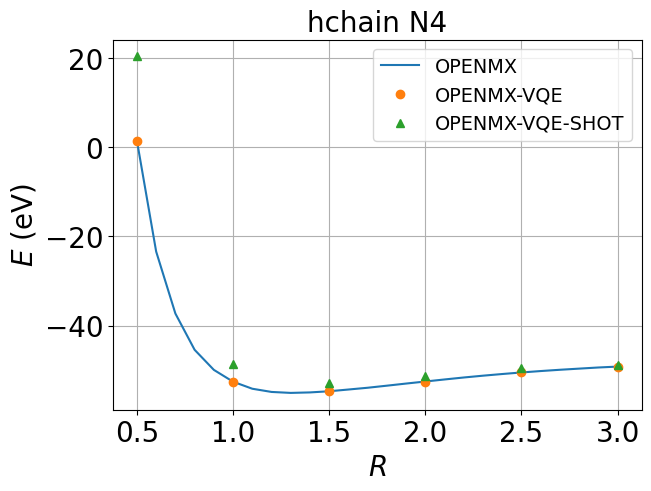

In [7]:
def show_E_R(dir_output, method=['vasp', 'espresso', 'wannier', 'openmx', 'openmx-vqe'], show_cvg=False):
    system, params = dir_output.split('/')[::2]
    marker = ['none', 'o', '^']
    linestyle=['-', 'none', 'none']
    out_dict = {
        'vasp': 'OUTCAR',
        'espresso': 'espresso.pwo',
        'wannier': 'wannier.eig',
        'openmx': 'openmx.out',
        'openmx-vqe': 'openmx.out',
        'openmx-vqe-shot': 'openmx.out',
    }

    data = []
    for m in method:
        fn_list = [f'{dir_output}/{dn}/{out_dict[m]}' for dn in os.listdir(dir_output) if re.match(f'{m}_R', dn)]
        fn_list = [fn for fn in fn_list if os.path.isfile(fn)]
        data_m = []
        if re.match('openmx', m):
            for fn in fn_list:
                max_iter, num_iter, energy = [], [], []
                for line in open(fn, 'r'):
                    if re.search('scf.maxIter', line): max_iter.append(int(line.split()[1]))
                    elif re.search('SCF=', line): num_iter.append(int(line.split()[1]))
                    elif re.search('Utot[.]', line): energy.append(float(line.split()[1]) * scipy.constants.physical_constants['Hartree energy in eV'][0])
                data_m.append([re_float('_R', fn), energy[0], max_iter[0] == num_iter[-1]])
        elif m == 'wannier':
            for fn in fn_list:
                df = pd.read_csv(fn, sep=r'\s+', names=['atom', 'k', 'energy'], dtype={'atom':int, 'k':int, 'energy':float})
                data_m.append([re_float('_R', fn), df.loc[df['k']==1, 'energy'].sum()])
        else:
            for fn in fn_list:
                data_m.append([re_float('_R', fn), read(fn).get_potential_energy()])
        data_m = np.array(data_m)
        data.append(data_m[data_m[:, 0].argsort()])
    #data = np.array(data)

    fig, ax = plt.subplots(constrained_layout=True)
    for d, m, mk, ls in zip(data, method, marker, linestyle):
        ax.plot(d[:, 0], d[:, 1], marker=mk, linestyle=ls, label=f'{m.upper()}')
        if show_cvg: ax.scatter(d[:, 0], d[:, 1], c=d[:, 2], cmap='bwr')
    ax.set_xlabel(r'$R$')
    ax.set_ylabel(r'$E$ (eV)')
    ax.set_title(re.sub('_', ' ', f'{system} {params}'), fontsize='medium')
    ax.legend(fontsize='x-small')
    ax.grid(True)
    plt.show()

show_E_R('hchain/output/N4', method=['openmx', 'openmx-vqe', 'openmx-vqe-shot'], show_cvg=False)

<div>
<img src="fig/bs_eq_15.png" width="500"/>
</div>